In [1]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from datetime import datetime, timedelta, date
from collections import OrderedDict
import subprocess
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import nltk
plotting.style(21)

In [ ]:
### Pointwise Mutual Information for identifying related terms

pmi_data = pd.DataFrame()
list_bins = [[x,x+3] for x in range(1957,1985)]

for c,bin in enumerate(list_bins):
    data = data_loader.subset(data_version="lemmatized_pm",start_date=bin[0],end_date=bin[1],words=[],preprocess=True)
    pmi_df = frequency.get_pmi_table(data,"|".join([str(x) for x in range(bin[0],bin[1])]),12,'bureaucracy',text_column="text_lemmatized")
    pmi_df['period'] = "-".join([str(x) for x in list_bins[c]])
    pmi_data = pmi_data.append(pmi_df)

In [ ]:
d = pd.DataFrame()
for y in sorted(list(set(pmi_data['period']))):
    t = list(pmi_data[pmi_data['period'] == y].sort_values('npmi')['w'][1:50])
    d[y] = t
pmi_data.to_csv('/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/pmi-table-s3-w12-1957-1985.csv',index=False)
d.to_csv('/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/pmi-topwords-s12-w8-1957-1985.csv',index=False)

In [11]:
## Diachronic PMI

data = data_loader.subset(data_version="lemmatized_pm",start_date=1957,end_date=1986,words=["bureaucracy"])
data_windowed = utils.windowizer(data,words=["bureaucracy"],window=24,id_column="id",text_column="text_lemmatized")

KeyboardInterrupt: 

In [3]:
totals = pd.read_csv('/media/ruben/Elements/PhD/data/hansard/resources/character_counts_year_pm.csv')
totals = dict(zip(totals['year'],totals['num_char']))

In [64]:
words = [[w for w in t.split(' ')] for t in list(data_windowed['window'])]
words = [item for sublist in words for item in sublist]
words = dict(Counter(words))
words = dict({k:v for k,v in words.items() if k not in nltk.corpus.stopwords.words('english') and v > 50 and len(k) > 3})

In [4]:
def get_pmi_score(data,word1,word2,year):
    data_path = "/media/ruben/Elements/PhD/data/hansard/lemmatized_pm"
    f1 = len(data_windowed[(data_windowed.id.str.split('-').str[2].str.split('.').str[-1].astype(int).isin([year]))])
    p1 = f1 / totals[year]
    f2 = int(subprocess.check_output(f'egrep -iE "{word2}"  {data_path}/*{year}* | wc -l',shell=True).decode('utf-8'))  
    p2 = f2 / totals[year]
    f12 = len(data_windowed[(data_windowed.id.str.split('-').str[2].str.split('.').str[-1].astype(int) == year) & (data_windowed.window.str.contains(word2))])  
    p12 = f12 / totals[year]
    if p12 > 0:
        try:
            # PMI
            pmi_ = math.log(((p12) / (p1 * p2)), 2)
            npmi = pmi_ / - math.log(p12)

            # DICE
            dice_ = (p12 * 2) / (p1 + p2)

            #ZSCORE
            j = f12
            s = 24
            p = f2 / (totals[year] - f1)
            e = p * f1 * s
            z_score = (j - e) / math.sqrt(e * (1-p))
            return [pmi_,npmi,dice_,z_score]
        except Exception as e:
            print(e)
            return 0

In [68]:
pmi_data = []

for t in tqdm(list(words.keys())):
    for y in range(1957,1986):
        s = get_pmi_score(data_windowed,"bureaucracy",t,y)
        if s:
            pmi_data.append([t,y] + s)

100%|██████████| 340/340 [48:03<00:00,  8.48s/it]


In [70]:
pmi_data = pd.DataFrame(pmi_data,columns=['t','y','pmi','npmi','dice','zscore']).fillna(0)

In [73]:
pmi_data.to_csv('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/collocations-bureaucracy-topterms-1957-1985.csv')

In [3]:
pmi_data = pd.read_csv('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/tables/collocations-bureaucracy-topterms-1957-1985.csv')
pmi_data = pmi_data.iloc[:,1:]

In [24]:
def plot_(words,blacklist=[],measure='dice',rolling=True,rolling_window=4,save=False,title=''):
    words = [w for w in words if w not in blacklist]
    d = pmi_data[pmi_data['t'].isin(words)]
    d = d[['t','y',measure]].reset_index(drop=True)
    d[measure] = d[measure].astype(float)
    d['y'] = d['y'].astype(int)
    d = d.pivot(index='y',columns='t',values=measure).reset_index().fillna(0.0)
    if rolling == True:
        for c in list(d.columns)[1:]:
            d[c] = d[c].rolling(rolling_window, win_type='gaussian').sum(std=3)
    fig, ax = plt.subplots()
    d.plot(x='y',y=words,figsize=(20,10),marker="o",ax=plt.gca(),cmap='Paired')
    ax.legend(title="Parties",fontsize=20)
    if save == True:
        plt.savefig(f'/home/ruben/Documents/GitHub/CrisisBureaucracy/results/plots/{title}.png',dpi=250)
    plt.show()

def ms(model,word,n):
    most_sims = model.wv.most_similar(word,topn=5000)
    return sorted([k for k,v in dict(most_sims).items() if k in list_words][:n] + [word])

In [25]:
m = KeyedVectors.load_word2vec_format('/media/ruben/Elements/PhD/casebureaucracy/w2v-models/model-single-sample.bin',binary=True)

In [26]:
list_words = list(set(pmi_data['t']))

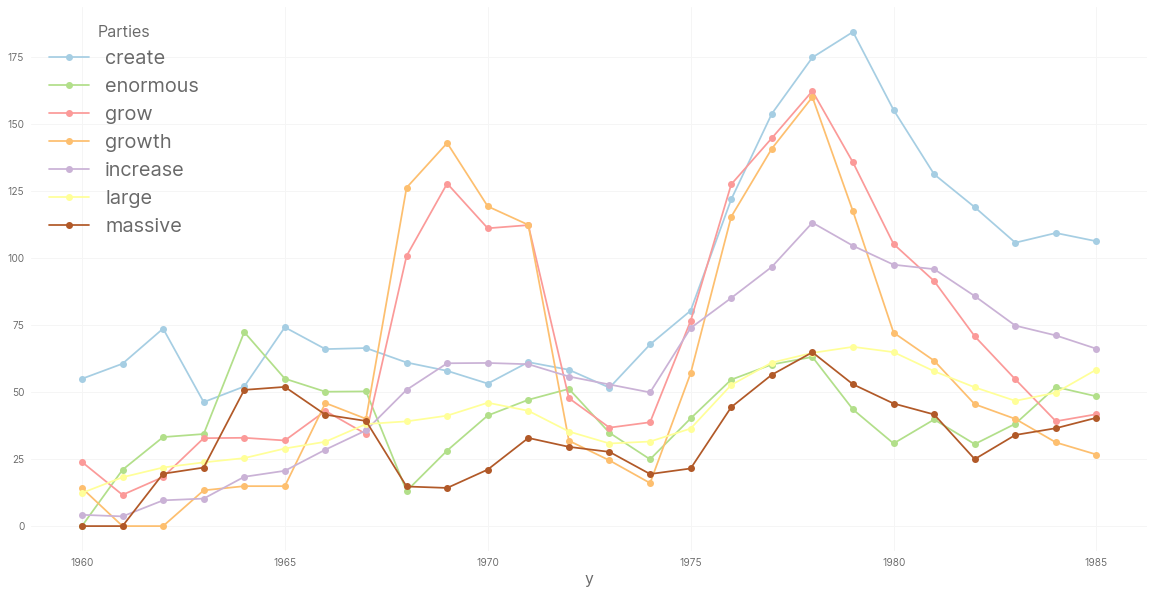

In [27]:
plot_(words="create enormous grow growth increase large massive".split(' '),measure='zscore',rolling=True,save=True,title='growth-pmi-terms-dia')

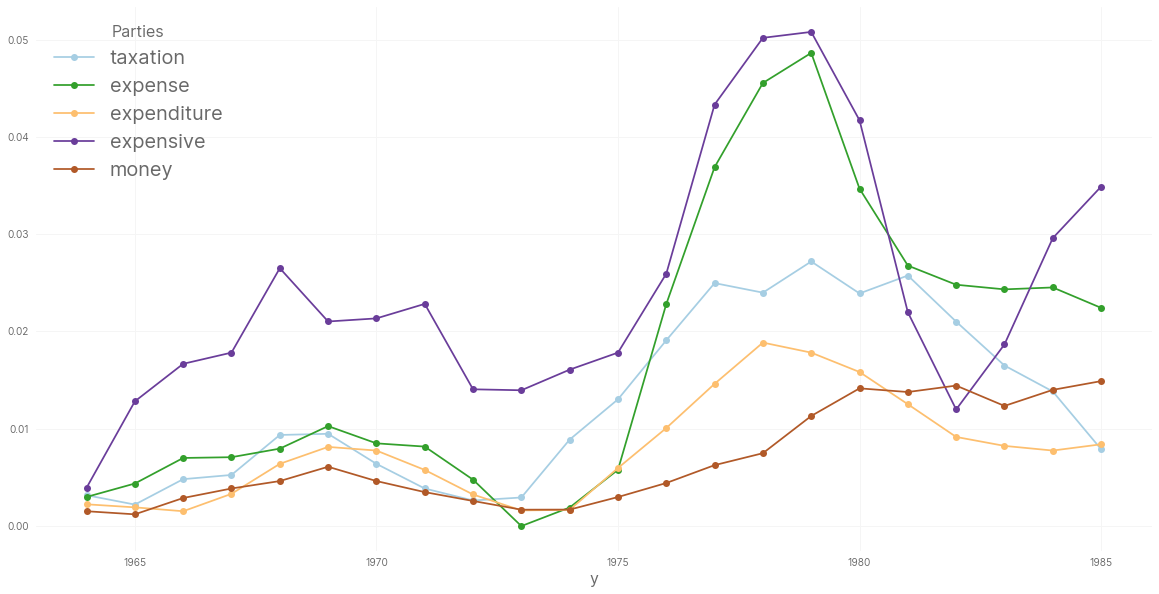

In [32]:
''